 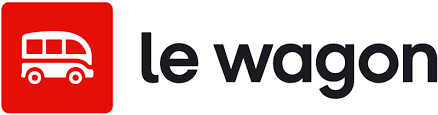

# Orders clustering

The purpose of the exercise is to extract different "typical profiles" of orders and consumers from Greenweez's turnover data. To achieve this, we will apply unsupervised learning algorithms to create order clusters.

## Orders clustering

a) Execute the cell below to load  the data into a `df` variable.

It will select 50k orders randomly (`ORDER BY rand()` in the SQL query).

In [1]:
from google.colab import auth
import pandas as pd
import pandas_gbq

# get credentials
auth.authenticate_user()

query = '''
SELECT turnover_grocery, turnover_beauty, turnover_baby, turnover_home, turnover_fresh, promo_rate
FROM `data-analytics-bootcamp-363212.course33.gwz_orders_segmentation`
ORDER BY rand()
LIMIT 50000
'''
df = pandas_gbq.read_gbq(query, project_id="data-analytics-bootcamp-363212")
df.head()

Downloading: 100%|██████████|


turnover_grocery  turnover_beauty  turnover_baby  turnover_home  \
0              0.00            27.17          19.51          15.30   
1              0.00             0.00          86.60           0.00   
2              0.00            23.65           0.00           0.00   
3             71.03            19.69           0.00          12.03   
4            176.48             2.83           0.00          17.36   

   turnover_fresh  promo_rate  
0             0.0    0.058195  
1             0.0         NaN  
2             0.0    0.150000  
3             0.0    0.040442  
4             0.0    0.035290

b) Which features do you see?

In [2]:
df.columns

Index(['turnover_grocery', 'turnover_beauty', 'turnover_baby', 'turnover_home',
       'turnover_fresh', 'promo_rate'],
      dtype='object')

Are there any null values?

In [3]:
df.isnull().sum()

turnover_grocery        0
turnover_beauty         0
turnover_baby           0
turnover_home           0
turnover_fresh          0
promo_rate          16115
dtype: int64

c) Replace null values (if any exist) with 0 using `fillna()`

In [4]:
df.fillna(0, inplace=True)

In [5]:
df.isnull().sum()

turnover_grocery    0
turnover_beauty     0
turnover_baby       0
turnover_home       0
turnover_fresh      0
promo_rate          0
dtype: int64

d) In a variable called `df_orders`, keep all the turnover columns from the original df. These features will help us cluster orders.

In [6]:
df_orders = df.drop(columns=["promo_rate"])

e) Use plotly.express and a box chart to see if the distribution of turnover is different per category (i.e. feature).

In [7]:
import plotly.express as px

px.box(df_orders)

f) Most entries for the column 'turnover_fresh' do not differ from zero, it seems like people are not purchasing these products enough to conduct a meaningful analysis.

Delete the `turnover_fresh` column from `df_orders`.

In [8]:
df_orders = df_orders.drop(columns=["turnover_fresh"])

df_orders.head()

turnover_grocery  turnover_beauty  turnover_baby  turnover_home
0              0.00            27.17          19.51          15.30
1              0.00             0.00          86.60           0.00
2              0.00            23.65           0.00           0.00
3             71.03            19.69           0.00          12.03
4            176.48             2.83           0.00          17.36

g) Train a first kmeans algorithm with two a-priori clusters. Remember that distance based models, such as k-means, are greatly effected by scale. Be sure to standardize your data appropriately.


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

simple_scaler = StandardScaler().fit(df_orders)

df_orders_scaled = pd.DataFrame(simple_scaler.transform(df_orders), columns=df_orders.columns)

df_orders_scaled.head()

simple_kmeans = KMeans(n_clusters=2, n_init=10).fit(df_orders_scaled)

df_orders['k_means_pred'] = simple_kmeans.labels_
df_orders.head(3)


turnover_grocery  turnover_beauty  turnover_baby  turnover_home  \
0               0.0            27.17          19.51           15.3   
1               0.0             0.00          86.60            0.0   
2               0.0            23.65           0.00            0.0   

   k_means_pred  
0             0  
1             1  
2             0

Why are we adding the labels to the original df rather than the scaled one?

We will be passing the scaled dataframe through further models and we don't want to feed our predicted answers into the models, that would be cheating! 🙀

h) What is inertia for a clustering algorithm? What is inertia for this model?

Inertia measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K )

In [10]:
simple_kmeans.inertia_

160350.92842536973

i) How do we know if 2 clusters a priori was a good choice or not?
Which method could you use?

The elbow method will allow of to check inertias with differing numbers of starting clusters.

j) You will use elbow method.

You will need to loop over different values of  𝑘  (in range 1 to 10) and stores the inertia at each iteration in order to plot its evolution and select the best  𝑘.

Complete code below to do so.

In [11]:
inertias = []
n_k = range(1, 10)

# for each number of centroids
for k in n_k:

    # train Kmeans algorithm
    km = KMeans(n_clusters=k, n_init=10).fit(df_orders_scaled)
    # store inertia
    inertias.append(km.inertia_)

inertias

[199999.99999999924,
 160350.92842536973,
 132654.15115556863,
 112944.23810861548,
 94147.74802443366,
 79662.22191615733,
 69220.34451795135,
 61978.37281355879,
 55183.96877071823]

k) Use plotly.express to display a line chart of all inertias.

Which number of cluster you recommend and why?

In [12]:
fig = px.line(y=inertias,
              x=range(1, 10),
              labels={'x': 'nb centroids', 'y':'Inertia'},
              title="Elbow method")
fig.show()

<details>
    <summary><i>Solution</i></summary>

It's hard to say for certain, but there could be some elbows between 3 and 5, so let's take 4 clusters as middle ground.
</details>

l) Train a new model with 4 clusters a priori. Use parameter n_init=100 to select best model among 100 tries.

Use `predict()` method to predict in which cluster each row of `df_orders` belong to. We will store results in a `labels` variable.

In [13]:
km = KMeans(n_clusters=4, n_init=100)

labels = km.fit_predict(df_orders_scaled)

m) Use [countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html) function of seaborn library to count visualize number of samples per cluster. It is well distributed?

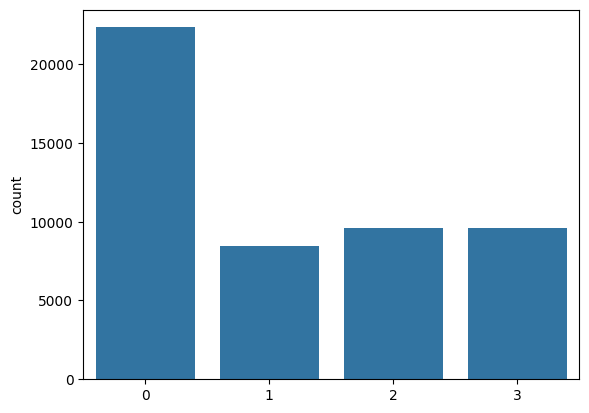

In [14]:
import seaborn as sns

sns.countplot(x=labels);

One bigger cluster and one much smaller... but overall, orders are well distributed.

n) Each KMeans cluster has a center (centroid).

You can get the values of the center for each cluster using the `.cluster_centers_` attribute on your KMeans object.

Create a DataFrame with each cluster's centroid values and the names of the features that the model has been trained on.

In [15]:
pd.DataFrame(km.cluster_centers_, columns=df_orders_scaled.columns)

turnover_grocery  turnover_beauty  turnover_baby  turnover_home
0         -0.323830        -0.299752      -0.342705       0.276710
1         -0.480424        -0.439203       1.833482      -0.282571
2         -0.317729         1.392986      -0.393533      -0.167693
3          1.491629        -0.303472      -0.418873      -0.229384

o) What conclusions can you draw? What are the different order profiles that emerge?

<details>
    <summary><i>Solution</i></summary>

Remember that the values in each column are the relative coordinates for each centroid across the features. The greater the magnitude of a feature for a cluster, the more important that feature is to that cluster.

In the example above we can see 3 types of orders : 1 with mostly groceries, 1 with baby products and 1 that is more evenly distributed mainly mixing beauty and home products.
</details>

p) Add to `df` a new column label containing labels of each sample.

In [16]:
df["label"] = labels

q) What does this instruction do? What can you say?

In [17]:
df[df["promo_rate"] > 0].groupby("label").size() / df.groupby("label").size()

label
0    0.611146
1    0.650942
2    0.744668
3    0.788285
dtype: float64

Where the promotion rate is greater than zero, we can see that the cluster we have associated with greater grocery turnover uses promotion codes more than others.